# Pre-procesamiento de Datos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno

## Lectura de las bases de datos

La presente base de datos es un conjunto de mediciones cardiorrespiratorias adquiridas durante 18 pruebas de ejercicio gradual máximas con cicloergómetro. Los datos corresponden a los intervalos de onda R a onda R del corazón, consumo de oxígeno y producción de potencia mecánica latido a latido registrados a lo largo de las sesiones de prueba de ejercicio graduadas. Los participantes son 18 atletas adolescentes (15,2 ± 2 años), pertenecientes a una división regional de kayak de velocidad y triatlón o una división nacional de esgrima [1][2].

In [2]:
subjects = pd.read_csv("subject-info.csv") # df va a ser nuestro target dataframe
measures = pd.read_csv("test_measure.csv") # df1 va a ser nuestro 1er categories dataframe

In [3]:
subjects.shape

(18, 7)

In [4]:
subjects.head()

,ID,age,Weight,Height,P_vt1,P_vt2,sport
0,1,15,53.7,161,50,140,fencing
1,2,15,56.2,162,80,127,fencing
2,3,16,89.9,191,155,300,fencing
3,4,16,76.5,180,215,275,fencing
4,5,17,76.4,186,110,172,fencing


In [5]:
measures.shape

(52062, 5)

In [6]:
measures.head()

,ID,time,RR,VO2,power
0,1,-130.840,672.0,0.302008,0
1,1,-130.168,672.0,0.302008,0
2,1,-129.536,632.0,0.301336,0
3,1,-128.824,712.0,0.301336,0
4,1,-127.948,876.0,0.301336,0


## Calculamos Delta Time, Cumsum Delta Time y Time Groups

Estas nuevas columnas nos ayudaran a agrupar la data de la base de datos 'measures' cada 1 minuto.

In [7]:
measures['delta_time'] = abs(measures['time'].diff()) # creamos la columna delta time
measures.at[0, 'delta_time'] = 0 # corregimos el primer delta de la serie
measures.loc[measures.delta_time > 2, 'delta_time'] = 0 # corregimos algunas direncias erroneas por salto de los registros entre atletas.

In [8]:
# Acumulamos los delta de tiempo, para crear una columna de tiempo acumulado iniciando en 0. Tomado de [3]
measures['cumsum_delta_time'] = measures.groupby('ID')['delta_time'].transform(pd.Series.cumsum)
measures.head()

,ID,time,RR,VO2,power,delta_time,cumsum_delta_time
0,1,-130.840,672.0,0.302008,0,0.000,0.000
1,1,-130.168,672.0,0.302008,0,0.672,0.672
2,1,-129.536,632.0,0.301336,0,0.632,1.304
3,1,-128.824,712.0,0.301336,0,0.712,2.016
4,1,-127.948,876.0,0.301336,0,0.876,2.892


In [9]:
# Generamos los indices de los grupos de tiempo, cada 1 min.
measures['time_groups'] = np.floor(measures['cumsum_delta_time']/60).astype(int)
measures

,ID,time,RR,VO2,power,delta_time,cumsum_delta_time,time_groups
0,1,-130.840,672.0,0.302008,0,0.000,0.000,0
1,1,-130.168,672.0,0.302008,0,0.672,0.672,0
2,1,-129.536,632.0,0.301336,0,0.632,1.304,0
3,1,-128.824,712.0,0.301336,0,0.712,2.016,0
4,1,-127.948,876.0,0.301336,0,0.876,2.892,0
...,...,...,...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0,0.536,1128.764,18
52058,18,947.816,528.0,0.507071,0,0.528,1129.292,18
52059,18,948.344,528.0,0.507071,0,0.528,1129.820,18
52060,18,948.884,540.0,0.507071,0,0.540,1130.360,18


## Eliminar columnas irrelevantes

Eliminamos las columnas de apoyo que nos ayudaron a agrupar cada 1 minuto

In [10]:
measures = measures.drop(['time', 'delta_time', 'cumsum_delta_time'], axis='columns')
measures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52062 entries, 0 to 52061
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           52062 non-null  int64  
 1   RR           50914 non-null  float64
 2   VO2          52062 non-null  float64
 3   power        52062 non-null  int64  
 4   time_groups  52062 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 2.0 MB


Eliminamos la columna de 'sport' del dataframe 'subjects', debido a que no nos es relevante el tipo de ejercicio realizado.

In [11]:
subjects = subjects.drop(['sport'], axis='columns')
subjects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      18 non-null     int64  
 1   age     18 non-null     int64  
 2   Weight  18 non-null     float64
 3   Height  18 non-null     int64  
 4   P_vt1   18 non-null     int64  
 5   P_vt2   18 non-null     int64  
dtypes: float64(1), int64(5)
memory usage: 992.0 bytes


## Revisar si hay NaNs

<Axes: >

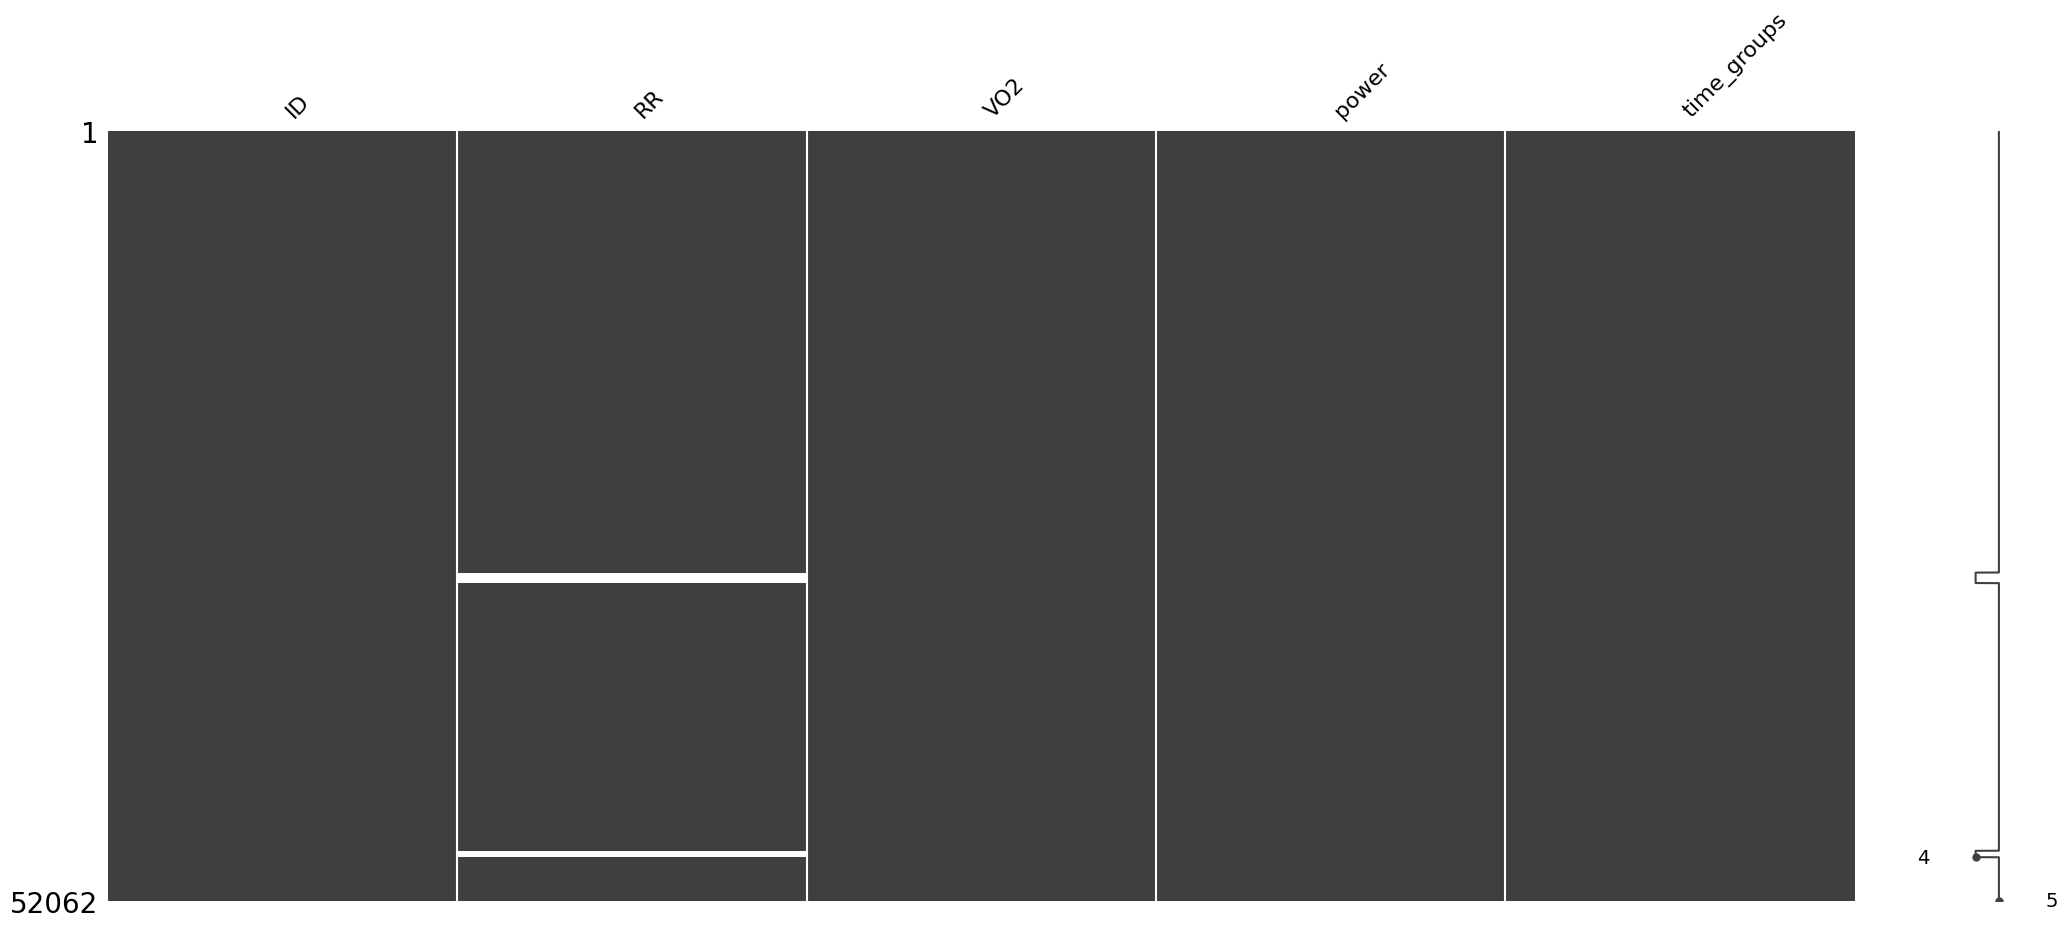

In [12]:
msno.matrix(measures)

In [13]:
measures.isnull().sum()

ID                0
RR             1148
VO2               0
power             0
time_groups       0
dtype: int64

Hay gran cantidad de NaN en la columna RR, debido a que son muchos y estan en datos muy cercanos (ya que la estructura de la base de datos esta relacionada) es mejor eliminarlos.

In [14]:
measures = measures.dropna(axis='rows')

## Unir DataFrames

El objetivo es ver las variaciones en la variable 'RR'. Por lo tanto, agrupamos la base de datos 'measures' por 'ID' y 'time_gropus' para obtener las STD de cada actividad por paciente y por carga de trabajo. Ademas, calculamos la media de 'VO2'y 'power' que seran adicionadas a nuestras variables categoricas.

In [15]:
SDRR = measures.groupby(['ID', 'time_groups'], as_index=False).std()
SDRR = SDRR.drop(['ID', 'power', 'VO2', 'time_groups'], axis='columns')
SDRR.head()

,RR
0,65.255079
1,56.761526
2,125.366943
3,27.770891
4,11.290313


In [16]:
SDRR.shape

(384, 1)

In [17]:
means = measures.groupby(['ID', 'time_groups'], as_index=False).mean()
means = means.drop(['RR','time_groups' ], axis='columns')
means.head()

,ID,VO2,power
0,1,0.334919,0.000000
1,1,0.338532,0.000000
2,1,0.445355,43.085106
3,1,0.784281,50.000000
4,1,0.981760,50.000000


In [18]:
means.shape

(384, 3)

In [19]:
# unimos las bases de datos para crear una sola con toda la información
df_temp = pd.concat([means, SDRR], axis=1)
df = subjects.merge(df_temp, left_on='ID', right_on='ID')
# cambiamos algunos nombres de los encabezados
df = df.rename(columns={'VO2':'mean_VO2', 'power':'mean_power', 'RR':'SDRR'})
df.head()

,ID,age,Weight,Height,P_vt1,P_vt2,mean_VO2,mean_power,SDRR
0,1,15,53.7,161,50,140,0.334919,0.000000,65.255079
1,1,15,53.7,161,50,140,0.338532,0.000000,56.761526
2,1,15,53.7,161,50,140,0.445355,43.085106,125.366943
3,1,15,53.7,161,50,140,0.784281,50.000000,27.770891
4,1,15,53.7,161,50,140,0.981760,50.000000,11.290313


In [20]:
df.shape

(384, 9)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 0 to 383
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          384 non-null    int64  
 1   age         384 non-null    int64  
 2   Weight      384 non-null    float64
 3   Height      384 non-null    int64  
 4   P_vt1       384 non-null    int64  
 5   P_vt2       384 non-null    int64  
 6   mean_VO2    384 non-null    float64
 7   mean_power  384 non-null    float64
 8   SDRR        384 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 30.0 KB


## Eliminar columnas irrelevantes

Una vez fuciondos los Dataframe eliminamos la columna de 'ID' debido a que ya no proporciona información relevante.

In [22]:
df = df.drop(['ID'], axis='columns')

# Pre-procesing y EDA

<Axes: >

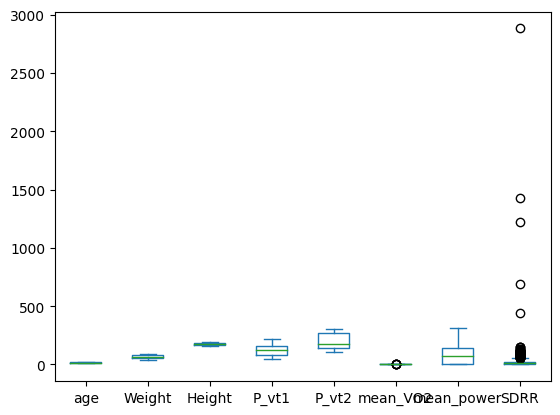

In [23]:
df.plot(kind="box")

In [24]:
from sklearn.preprocessing import RobustScaler

In [25]:
X = df.drop('SDRR', axis=1)
y = df['SDRR']
X_columns = X.columns
X_columns

Index(['age', 'Weight', 'Height', 'P_vt1', 'P_vt2', 'mean_VO2', 'mean_power'], dtype='object')

In [26]:
scaler_robust = RobustScaler()
scaler_robust.fit(X)

RobustScaler()

In [27]:
# Escalamos X
X = scaler_robust.transform(X)
X = pd.DataFrame(X, columns=X_columns)

In [28]:
df_scaled = pd.concat([X, y], axis=1,)
df_scaled.head()

,age,Weight,Height,P_vt1,P_vt2,mean_VO2,mean_power,SDRR
0,-0.333333,-0.429603,-0.888889,-1.0,-0.260163,-0.924926,-0.485675,65.255079
1,-0.333333,-0.429603,-0.888889,-1.0,-0.260163,-0.921292,-0.485675,56.761526
2,-0.333333,-0.429603,-0.888889,-1.0,-0.260163,-0.813844,-0.189051,125.366943
3,-0.333333,-0.429603,-0.888889,-1.0,-0.260163,-0.472935,-0.141444,27.770891
4,-0.333333,-0.429603,-0.888889,-1.0,-0.260163,-0.274301,-0.141444,11.290313


<Axes: >

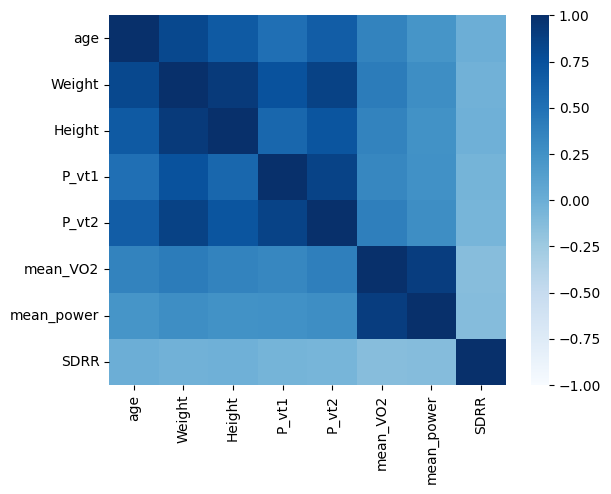

In [29]:
sns.heatmap(df_scaled.corr(), vmin=-1, vmax=1, cmap="Blues")

<Axes: >

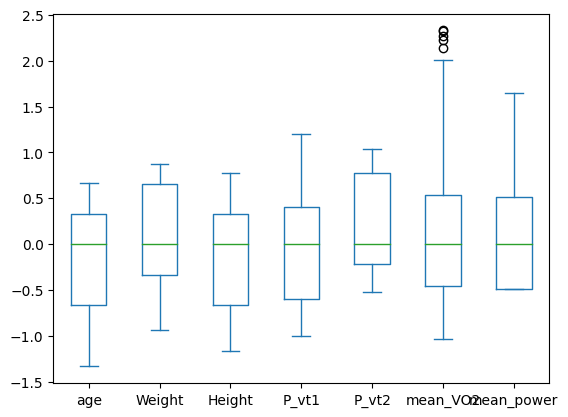

In [30]:
X.plot(kind="box")

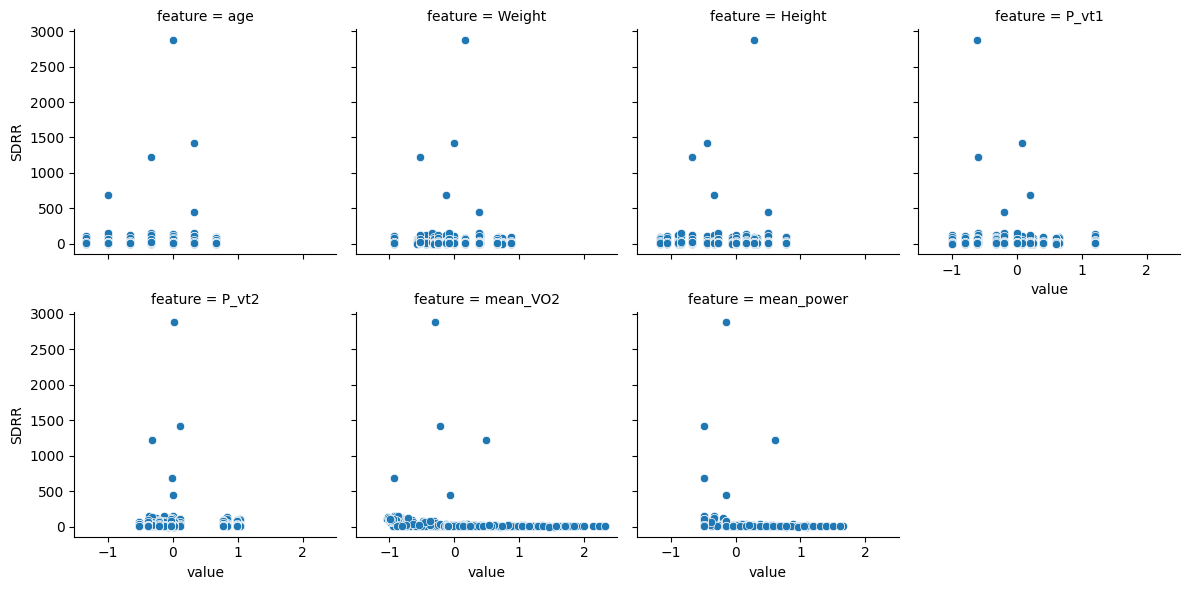

In [31]:
# Visualizamos las variables independientes vs la variable dependiente con un scatter plot
m = df_scaled.melt(id_vars=['SDRR'], var_name='feature')
g = sns.FacetGrid(m, col='feature', col_wrap=4)
g.map_dataframe(sns.scatterplot, x='value', y='SDRR')

## Eliminar outliers

De las graficas anteriores, vemos que existen algunos datos outliers para la variable SDRR, por lo que los eliminamos antes de entrenar los modelos.

In [32]:
df_scaled = df_scaled.drop(df_scaled[df_scaled['SDRR']>250].index)

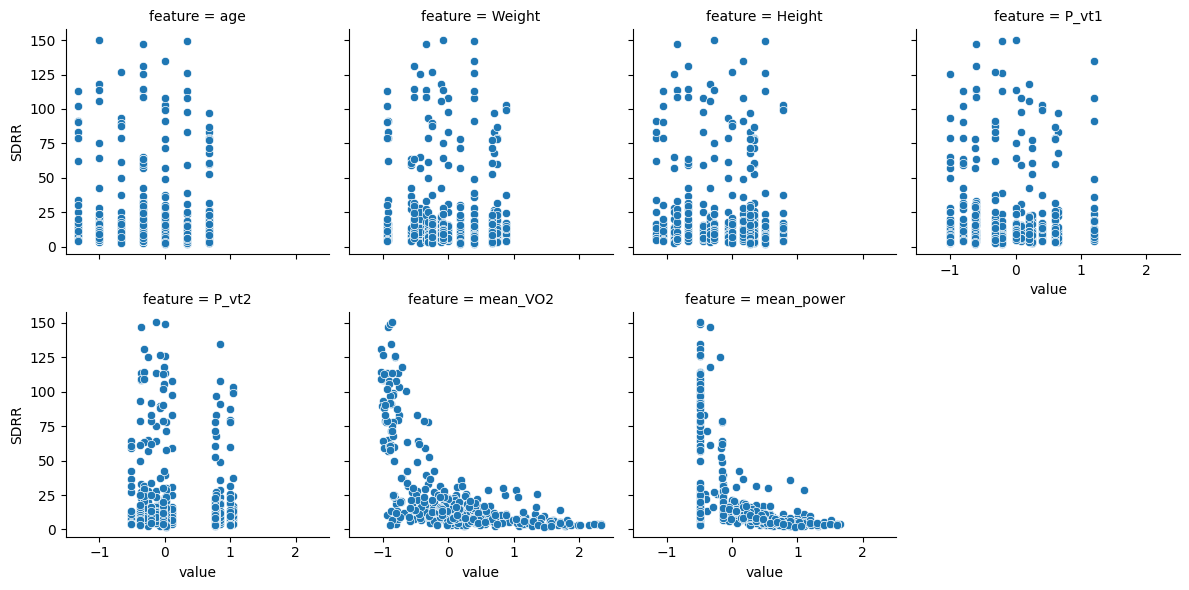

In [33]:
# Visualizamos nuevamente las variables independientes vs la variable dependiente con un scatter plot
m = df_scaled.melt(id_vars=['SDRR'], var_name='feature')
g = sns.FacetGrid(m, col='feature', col_wrap=4)
g.map_dataframe(sns.scatterplot, x='value', y='SDRR')

# Modelos de ML

Importamos los modelos de regresión de la libreria de SKLEARN


In [34]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, StackingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression

In [35]:
from sklearn.model_selection import train_test_split

Creamos nuevamente las variabes X, y

In [36]:
X = df_scaled.drop('SDRR', axis=1)
y = df_scaled['SDRR']

Separamos la data en entrenamiento y prueba

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30)

In [38]:
X_train.head()

,age,Weight,Height,P_vt1,P_vt2,mean_VO2,mean_power
351,-1.333333,-0.927798,-1.166667,-0.32,-0.219512,-0.448008,-0.149840
56,0.000000,0.877256,0.777778,0.40,1.040650,0.249503,-0.485675
134,-0.333333,-0.570397,-0.666667,-0.80,-0.520325,-0.986985,-0.485675
201,-0.666667,-0.245487,0.000000,-0.32,-0.081301,0.711025,0.783609
140,-0.333333,-0.570397,-0.666667,-0.80,-0.520325,-0.304634,0.062285


In [39]:
df.head()

,age,Weight,Height,P_vt1,P_vt2,mean_VO2,mean_power,SDRR
0,15,53.7,161,50,140,0.334919,0.000000,65.255079
1,15,53.7,161,50,140,0.338532,0.000000,56.761526
2,15,53.7,161,50,140,0.445355,43.085106,125.366943
3,15,53.7,161,50,140,0.784281,50.000000,27.770891
4,15,53.7,161,50,140,0.981760,50.000000,11.290313


In [40]:
# Modelos de regresión
mdl_knn = KNeighborsRegressor(n_neighbors=5)
mdl_svr = SVR(kernel="rbf")
mdl_tree = DecisionTreeRegressor()
mdl_ensemble = RandomForestRegressor(random_state=0)
mdl_ada = AdaBoostRegressor()
mdl_bagg = BaggingRegressor()
mdl_grad = GradientBoostingRegressor()
mdl_His = HistGradientBoostingRegressor()

In [41]:
list_mdl = [mdl_knn, mdl_svr, mdl_tree, mdl_ensemble, mdl_ada, mdl_bagg, mdl_grad, mdl_His, mdl_lin]
names_mdl = ["knn","svr","tree","randomforest","ada","bagging","gradientBoosting","histgradientBoosting"]
y_mdl_pred = list()

In [42]:
from sklearn.metrics import r2_score

In [43]:
for mdl in list_mdl:
    mdl.fit(X_train, y_train)
    y_mdl_pred.append(mdl.predict(X_test))

In [44]:
print("{:>15} {:>15}".format(*["Model","score"]))
for n, mdl in enumerate(y_mdl_pred):
    score = r2_score(y_test, mdl)
    show_values = [names_mdl[n],  np.round(score,2)]
    print("{:>20} {:>20}".format(*show_values))

          Model           score
                 knn                 0.43
                 svr                 0.07
                tree                 0.47
        randomforest                 0.63
                 ada                 0.64
             bagging                 0.61
    gradientBoosting                 0.64
histgradientBoosting                 0.72
              lineal                 0.38


In [45]:
from sklearn.model_selection import cross_val_score

In [46]:
print("{:>15} {:>15}".format(*["Model","score"]))
for n, mdl in enumerate(list_mdl):
    score = cross_val_score(mdl, X,y, cv=10)
    show_values = [names_mdl[n],  np.round(score.mean(),2)]
    print("{:>20} {:>20}".format(*show_values))

          Model           score
                 knn                 0.37
                 svr                 0.08
                tree                 0.39
        randomforest                 0.67
                 ada                  0.6
             bagging                 0.63
    gradientBoosting                 0.64
histgradientBoosting                 0.68
              lineal                 0.26


# Conclusiones

*   Fue importante revisar exhaustivamente la data en búsqueda de datos faltantes y outliers. Al entrenar el modelo sin revisar la presencia de outliers las métricas de desempeño fueron significativamente menores a las mostradas en este notebook.
*   Según el entrenamiento mediante CrossValidation los mejores modelos fueron Histogram-based Gradient Boosting y Random Forest. No obstante, los resultados no son tan buenos como se esperaban.
*   Podemos concluir que al realizar los modelos de ML con base en el agrupamiento de la data de todos los atletas, la relación entre la desviación estándar del tiempo entre ondas R y las variables categóricas existe. Sin embargo, no es tan robusta como para realizar predicciones.
*   Del paper revisado, el cual concluye que existe una relación entre el esfuerzo del ejercicio y la desviación estándar del tiempo entre ondas R, estamos de acuerdo en su resultado, debido a que se aprecia una relación estadística. No obstante, como se dijo antes no es suficiente como predictor.

[1] Chabert, C., Mongin, D., Hermand, E., Collado, A., & Hue, O. (2022). Cardiorespiratory measurement from graded cycloergometer exercise testing (version 1.0.0). PhysioNet. https://doi.org/10.13026/2qs3-kh43.

[2] Mongin, D., Chabert, C., Extremera, M. G., Hue, O., Courvoisier, D. S., Carpena, P., & Galvan, P. A. B. (2022). Decrease of heart rate variability during exercise: An index of cardiorespiratory fitness. PLOS ONE, 17(9), Artículo e0273981. https://doi.org/10.1371/journal.pone.0273981

[3] How can I use cumsum within a group in Pandas? (s.f.). Stack Overflow. https://stackoverflow.com/questions/32847800/how-can-i-use-cumsum-within-a-group-in-pandas